In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
from copy import deepcopy
from weighted_levenshtein import lev
import time

from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import streaming_classifier, max_min_range_classifier


In [2]:
waves, labels, samprate = load_training_data(path = "Datasets/data/",
                                             scale_factor= 1,
                                             #blacklist = ['data8'],
                                             whitelist = ["data"])


samprate = 10000


time_buffers = {"data3":(-0.3, 0.55),
                "data2":(-0.3, 0.55),
                "data0":(-0.3, 0.55),
                "data1":(-0.3, 0.55),
                "data5":(-0.5, 0.75),
                "data4":(-0.5, 0.75)}


dict_keys(['data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7', 'data8']) dict_keys(['data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7', 'data8'])
c:\Users\darap\Documents\School\University\2021, Sem. 1\DATA3888\Aqua10\Classifier\load_data.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


In [3]:
def my_lev_dist(prediction, actual, sub_L_cost = 1.25, sub_R_cost = 1.25, sub_under_score_cost = 0.5, delete_under_score_cost = 0, delete_L_cost = 1.25, delete_R_cost = 1.25):
    substitute_costs = np.ones((128, 128), dtype=np.float64)  
    substitute_costs[ord('L'), ord('R')] = sub_L_cost
    substitute_costs[ord('R'), ord('L')] = sub_R_cost
    substitute_costs[ord('_'), ord('L')] = sub_under_score_cost
    substitute_costs[ord('_'), ord('R')] = sub_under_score_cost
    
    delete_costs = np.ones(128, dtype=np.float64)
    delete_costs[ord('_')] = delete_under_score_cost
    delete_costs[ord('L')] = delete_L_cost
    delete_costs[ord('R')] = delete_R_cost

    return lev(prediction, actual, substitute_costs = substitute_costs, delete_costs = delete_costs)



def ts_zero_crossings(x):
    return np.sum(x[0:-1]*x[1::] <= 0)


In [4]:
det_window = 0.35
hyp_event_smart_threshold_factor = 0.31

hyp_event_smart_threshold_window = 5

window_size = 0.36
hyp_detection_buffer_end = (window_size - det_window) / 2
hyp_detection_buffer_start = (window_size - det_window) / 2

N_loops_over_window = int(np.ceil(window_size/0.05))

In [5]:
classifiers = {"Max-min-range": max_min_range_classifier}

file_accuracies = {}

for classifier_label, classifier in classifiers.items():
    print(classifier_label)
    for range_threshold in np.linspace(0, 100, 101):
        print("\nCurrent Range Threshold:", range_threshold)

        current_accuracies = []
        for i, key in enumerate(waves):
            
            predictions, predictions_timestamps, predictions_storage = streaming_classifier(
                waves[key],
                samprate,
                classifier = classifier,
                window_size = window_size, # time plotted in window [s]
                N_loops_over_window = N_loops_over_window, # implicitly defines buffer to be 1/x of the window
                total_time = None,  # max time
                hyp_detection_buffer_end = hyp_detection_buffer_end, # seconds - how much time to shave off either end of the window in order to define the middle portion
                hyp_detection_buffer_start = hyp_detection_buffer_start,
                hyp_event_smart_threshold_window = hyp_event_smart_threshold_window, 
                hyp_event_smart_threshold_factor = hyp_event_smart_threshold_factor, 
                hyp_calibration_statistic_function = lambda x: ts_zero_crossings(x)/(len(x)/samprate)*det_window, # Function that calculates the calibration statistic
                hyp_test_statistic_function = ts_zero_crossings, # Function that calculates the test statistic
                hyp_event_history = 30,
    #             hyp_timeout = 20,
                hyp_consecutive_triggers = 2,
                hyp_consecutive_reset = 10,
                using_max_min_range_classifier = classifier_label == "Max-min-range",
                max_min_range_threshold = range_threshold,
                plot = False,
                store_events = True, 
                verbose=False,
                live = False,
    #             dumb_threshold = True,
                flip_threshold = True
    #             timeout = True
        )
            actuals = "".join(labels[key].label)

            lev_dist = my_lev_dist(actuals, predictions)
            acc = abs(len(actuals) - lev_dist)/len(actuals)
            current_accuracies.append(acc)
        if range_threshold in file_accuracies:
            file_accuracies[range_threshold] += current_accuracies
        else:
            file_accuracies[range_threshold] = current_accuracies


ave_accuracies_per_range_val = {}
for height_thresh, acc_each_file_ls in file_accuracies.items():
    ave_accuracies_per_range_val[height_thresh] = sum(acc_each_file_ls) / len(acc_each_file_ls)
print("done")


#     plot_predictions(waves[key], samprate, labels[key], predictions, predictions_timestamps, ax, i,
#                      title="", before_buffer = 0.7, after_buffer = 1, actual_alpha=0.0,
#                      wave_alpha=1, pred_alpha = 0.5, miny = -100, maxy = 100)



Max-min-range

Current Range Threshold: 0.0

Current Range Threshold: 1.0

Current Range Threshold: 2.0

Current Range Threshold: 3.0

Current Range Threshold: 4.0

Current Range Threshold: 5.0

Current Range Threshold: 6.0

Current Range Threshold: 7.0

Current Range Threshold: 8.0

Current Range Threshold: 9.0

Current Range Threshold: 10.0

Current Range Threshold: 11.0

Current Range Threshold: 12.0

Current Range Threshold: 13.0

Current Range Threshold: 14.0

Current Range Threshold: 15.0

Current Range Threshold: 16.0

Current Range Threshold: 17.0

Current Range Threshold: 18.0

Current Range Threshold: 19.0

Current Range Threshold: 20.0

Current Range Threshold: 21.0

Current Range Threshold: 22.0

Current Range Threshold: 23.0

Current Range Threshold: 24.0

Current Range Threshold: 25.0

Current Range Threshold: 26.0

Current Range Threshold: 27.0

Current Range Threshold: 28.0

Current Range Threshold: 29.0

Current Range Threshold: 30.0

Current Range Threshold: 31.0

Cur

Text(0.5, 1.0, 'Classifier Accuracy vs. Range Threshold for Window Size of 0.36 Seconds')

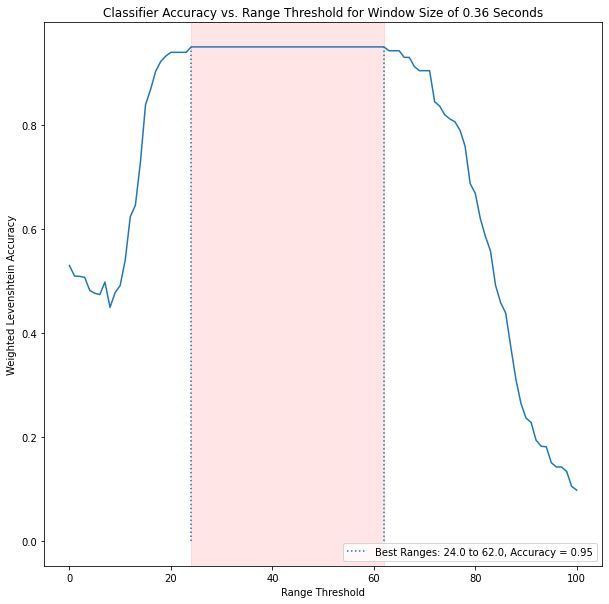

In [12]:
best_heights = []
best_value = 0
for acc in ave_accuracies_per_range_val.values():
    if round(acc, 5) > round(best_value, 5):  #need to round because python maintains its floats very imprecisly
        best_value = acc

for key, value in ave_accuracies_per_range_val.items():
    if round(value, 5) == round(best_value, 5):
        best_heights.append(key)

plt.figure(figsize=(10, 10))
plt.plot(ave_accuracies_per_range_val.keys(), ave_accuracies_per_range_val.values())
plt.vlines(best_heights[0], 0, best_value, linestyle=":", label=f"Best Ranges: {round(best_heights[0], 2)} to {round(best_heights[len(best_heights) - 1], 2)}, Accuracy = {round(best_value, 2)}")
plt.vlines(best_heights[len(best_heights) - 1], 0, best_value, linestyle=":")
plt.axvspan(best_heights[0], best_heights[len(best_heights) - 1], alpha=0.1, color='red')

plt.legend(loc = "lower right")
plt.ylabel("Weighted Levenshtein Accuracy")
plt.xlabel("Range Threshold")
plt.title("Classifier Accuracy vs. Range Threshold for Window Size of 0.36 Seconds")

